In [1]:
%pip install -q -U datasets evaluate accelerate python-iso639

In [2]:
from dataclasses import dataclass, asdict
from typing import Any
import datetime

import datasets
import transformers
from transformers import AutoModel, Trainer, AutoModelForAudioClassification, TrainingArguments, AutoFeatureExtractor
from torch.utils.data import DataLoader
import evaluate
from tqdm.auto import trange, tqdm
import numpy as np
import iso639

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
output_dir = "/content/drive/MyDrive/LangId Evaluation/minds-14_facebook-mms-lid-4017/"

# Global id helpers

In [4]:
def lower_letter_to_num(letter:str) -> int:
  """Returns the index of the english lowercase letter in the alphabet, with a zero-based index.
  The input string must be a single character and a lowercase letter.
  >>> lower_letter_to_num("a")
  0
  >>> lower_letter_to_num("z")
  25
  >>> lower_letter_to_num("k")
  10
  """
  assert len(letter) == 1, f'Letter "{letter}" must be a single letter'
  letter_ascii = ord(letter)
  letter_num = letter_ascii - ord('a')
  assert 0 <= letter_num <= 26, f'Letter "{letter}" must be a lowercase English (ASCII) letter'
  return letter_num

In [5]:
def iso639_part3_to_global_id(lang:str) -> int:
  """Converts an ISO 639-3 language to a unique integer id used across all models and datasets.
  ISO 639-3 is already a unique identifier, but parts of Huggingface modules require integers.

  Interprets the letters in the ISO 639-3 code as a base-26 number and converts that to an integer

  >>> iso639_part3_to_global_id("yue")
  16748
  >>> iso639_part3_to_global_id("eng")
  3048
  """
  assert len(lang) == 3, f'lang must be an ISO 639-3 language code. Got "{lang}"'
  return 26**2 * lower_letter_to_num(lang[0]) + 26 * lower_letter_to_num(lang[1]) + lower_letter_to_num(lang[2])

In [6]:
def letter_num_to_letter(letter_num:int) -> str:
  assert 0 <= letter_num < 26
  return chr(ord('a') + letter_num)

In [7]:
def global_id_to_iso639_part3(id:int) -> str:
  return letter_num_to_letter((id // (26 * 26)) % 26) + letter_num_to_letter((id // 26) % 26) + letter_num_to_letter(id % 26)

In [8]:
def language_to_global_id(lang:str) -> int:
  return iso639_part3_to_global_id(iso639.Language.match(lang).part3)

# Load model

In [9]:
model_id = "facebook/mms-lid-4017"
model = AutoModelForAudioClassification.from_pretrained(model_id)
# model.to_bettertransformer()
feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at facebook/mms-lid-4017 were not used when initializing Wav2Vec2ForSequenceClassification: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
-

Create mappings to/from model ids to global ids to make using other datasets on this model easier. We create a common interface that allows translation to a single target.

In [10]:
model_id_to_global_id = {
    model_id: iso639_part3_to_global_id(model.config.id2label[model_id])
    for model_id in model.config.id2label
}

In [11]:
global_id_to_model_id = {v:k for k, v in model_id_to_global_id.items()}

# Load and preprocess data

In [12]:
# On Google Colab cpu, runs at about 0.03 it/s, so 200 will take around 2 hours
minds_14 = datasets.load_dataset("PolyAI/minds14", "all", split="train").shuffle(seed=42).select(range(200))
minds_14

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for PolyAI/minds14 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/PolyAI/minds14
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 200
})

The label names in minds14 are ISO 639-1 codes with the locale (country) afterwards, separated by a hyphen ("en-us"). We take just the language code and use that to create the global id.

The label for Chinese Mandarin in `minds14` is "zh" while the label in `mms-lid-4017` is "cmn". Add a custom mapping to fix that discrepency.

In [13]:
minds_int2str = minds_14.features["lang_id"]._int2str
minds_str2int = minds_14.features["lang_id"]._str2int

In [14]:
dataset_id_to_global_id = {
    dataset_id: iso639_part3_to_global_id(
        iso639.Language.from_part1(minds_int2str[dataset_id].split("-")[0]).part3)
    for dataset_id in minds_14.features["lang_id"]._str2int.values()
}
dataset_id_to_global_id[minds_str2int["zh-CN"]] = iso639_part3_to_global_id("cmn")

In [15]:
# def map_dataset_id_to_global_id(dataset_id):
#   custom_mappings = {
#       minds_14.features["lang_id"]._str2int["zh-CN"]: language_to_global_id("cmn"),
#   }
#   if dataset_id in custom_mappings:
#     return custom_mappings[dataset_id]
#   dataset_label = minds_14.features["lang_id"]._int2str[dataset_id]
#   lang = iso639.Language.from_part1(dataset_label.split("-")[0]).part3
#   return language_to_global_id(lang)

Verify that all dataset languages map to a language in the model.

In [16]:
for name in minds_14.features["lang_id"].names:
  dataset_id = minds_14.features["lang_id"]._str2int[name]
  global_id = dataset_id_to_global_id[dataset_id]
  if global_id not in global_id_to_model_id:
    print(f"Warning: The language {name} (id {dataset_id}) in the dataset does not map to an id in the model."
    + "\nAdd a custom entry to the global_id_to_model_id dictionary")

In [17]:
minds_14 = minds_14.remove_columns(["path", "transcription", "english_transcription", "intent_class"])

In [18]:
minds_14 = minds_14.cast_column("audio", datasets.Audio(sampling_rate=16000))

In [19]:
def preprocess(sample):
  new_sample = feature_extractor(sample["audio"]["array"], sampling_rate=16_000, return_tensors="pt")
  new_sample["input_values"] = new_sample["input_values"][0]
  global_id = dataset_id_to_global_id[sample["lang_id"]]
  new_sample["label"] = global_id_to_model_id[global_id]
  return new_sample

In [20]:
minds_14 = minds_14.map(preprocess, batched=False, remove_columns=["audio"])

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [21]:
accuracy = evaluate.load("accuracy")

In [22]:
def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    # predictions = [model_id_to_global_id[model_id] for model_id in predictions]
    acc = accuracy.compute(predictions=predictions, references=labels)

    return {"acc": acc}

In [23]:
sample = next(iter(minds_14))

# Make inferences

In [25]:
args = TrainingArguments(
    output_dir=output_dir,
    per_device_eval_batch_size=1,
    logging_steps=25,
    jit_mode_eval=True,
)

In [26]:
trainer = Trainer(
    args=args,
    model=model,
    eval_dataset=minds_14,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [27]:
# eval_results = trainer.evaluate()
# eval_results

In [28]:
prediction_output = trainer.predict(minds_14)
prediction_output

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:4193: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:594: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:601: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace mig

PredictionOutput(predictions=array([[ 0.7059393 ,  1.3657916 ,  2.081416  , ..., -1.4826033 ,
        -1.5221775 , -0.9297071 ],
       [ 0.7141346 ,  1.2464135 ,  1.4554924 , ..., -1.4101557 ,
        -1.4367778 , -0.8332724 ],
       [ 3.1857033 ,  3.9418766 ,  7.1474333 , ..., -0.6406508 ,
         0.15081997, -0.51635814],
       ...,
       [ 1.687227  , -0.76437044,  2.3228178 , ..., -0.75961494,
        -1.2627834 , -1.3124855 ],
       [ 2.0182357 ,  2.354972  ,  3.9474669 , ..., -1.1567296 ,
        -1.587655  , -1.5957661 ],
       [-0.7269008 ,  1.4147288 ,  1.9821986 , ..., -1.9813855 ,
        -1.8721827 , -1.5818825 ]], dtype=float32), label_ids=array([106, 106,  26,   4,   2,  43,  44,  80,   2,  61,  43,   2,   8,
         4,   1,   8,   2,  26,   2,  13,  26,   4,   2,  61,   4,  44,
        44,  44,  80,   2,  13,  13,   4, 106,   2,   2,  43,  80,  80,
        80,   2,  43,   2,  80,   8,  61,   3,  43,  61,   1,   3,   2,
        44,   4,   8,  61,  13,   2,  43,  8

# Evaluate

In [38]:
# Logits to preictions, using the model's ids
predictions_model_ids = np.argmax(prediction_output.predictions, axis=-1)
label_model_ids = prediction_output.label_ids

In [39]:
predictions_global_ids = [model_id_to_global_id[id] for id in predictions_model_ids]
label_global_ids = [model_id_to_global_id[id] for id in label_model_ids]

In [40]:
unique_prediction_ids = np.unique(predictions_model_ids)
unique_prediction_labels = [model.config.id2label[id] for id in unique_prediction_ids]

In [41]:
import sklearn
print(sklearn.metrics.classification_report(
    y_true=label_model_ids,
    y_pred=predictions_model_ids,
    labels=unique_prediction_ids,
    target_names=unique_prediction_labels,
    zero_division=0,
))

              precision    recall  f1-score   support

         cmn       1.00      0.86      0.92         7
         eng       0.92      0.87      0.89        39
         spa       1.00      0.44      0.62         9
         fra       1.00      1.00      1.00        14
         mlg       0.00      0.00      0.00         0
         por       1.00      0.80      0.89        20
         kor       1.00      0.94      0.97        18
         rus       1.00      0.82      0.90        11
         slv       0.00      0.00      0.00         0
         bul       0.00      0.00      0.00         0
         pol       1.00      1.00      1.00        19
         nld       1.00      1.00      1.00        19
         cym       0.00      0.00      0.00         0
         deu       1.00      1.00      1.00        14
         lit       0.00      0.00      0.00         0
         kaz       0.00      0.00      0.00         0
         sqi       0.00      0.00      0.00         0
         ces       1.00    

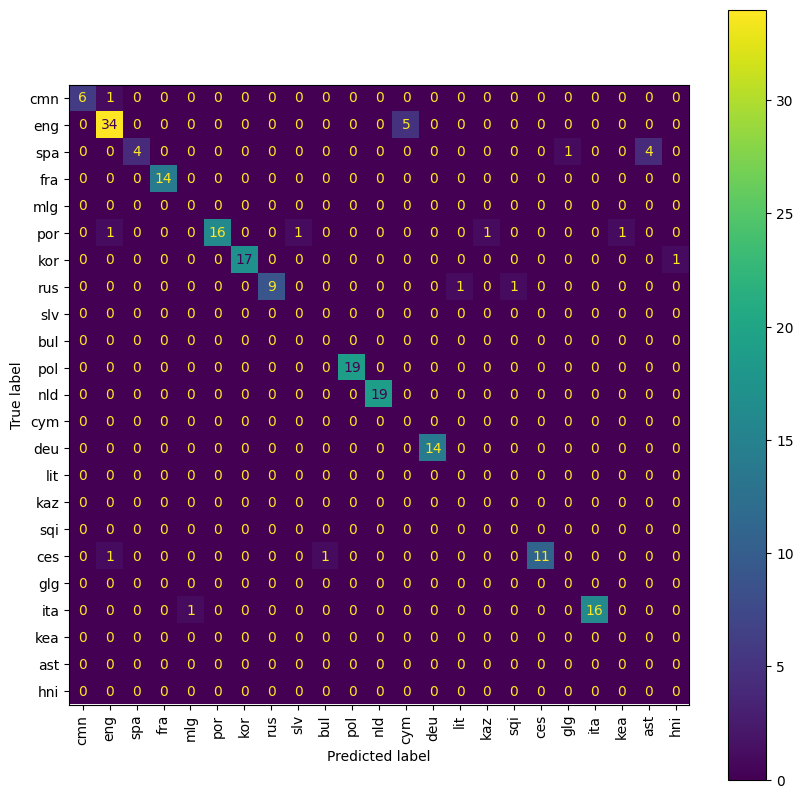

In [42]:
import matplotlib.pyplot as plt
cm = sklearn.metrics.confusion_matrix(
    y_true=label_model_ids,
    y_pred=predictions_model_ids,
    labels=unique_prediction_ids,
)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                              display_labels=unique_prediction_labels)

fig, ax = plt.subplots(figsize=(10,10))

disp.plot(ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
ax.tick_params(axis="x", labelrotation=90)
fig.savefig(output_dir + "/confusion matrix.png")
fig.savefig(output_dir + "/confusion matrix.svg")
fig.show()

In [43]:
accuracy = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
accuracy = accuracy.diagonal()

<ipython-input-43-1a19b2c087c2>:1: RuntimeWarning: invalid value encountered in divide
  accuracy = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]


In [44]:
nans = ~np.isnan(accuracy)
accuracy = accuracy[nans]
labels = np.array(unique_prediction_labels)[nans]

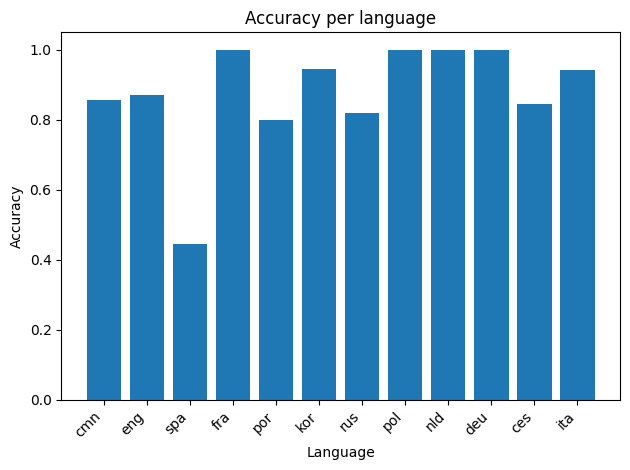

In [45]:
plt.bar(np.arange(len(accuracy)), accuracy, label=labels)
plt.title("Accuracy per language")
plt.ylabel("Accuracy")
plt.xlabel("Language")
plt.yticks(np.linspace(0, 1, num=6))
plt.xticks(np.arange(len(accuracy)), labels, rotation=45, horizontalalignment="right")
# Prevent labels from getting cut off when saving image
plt.tight_layout()

plt.savefig(output_dir + "/accuracy bar plot.png")
plt.savefig(output_dir + "/accuracy bar plot.svg")
plt.show()

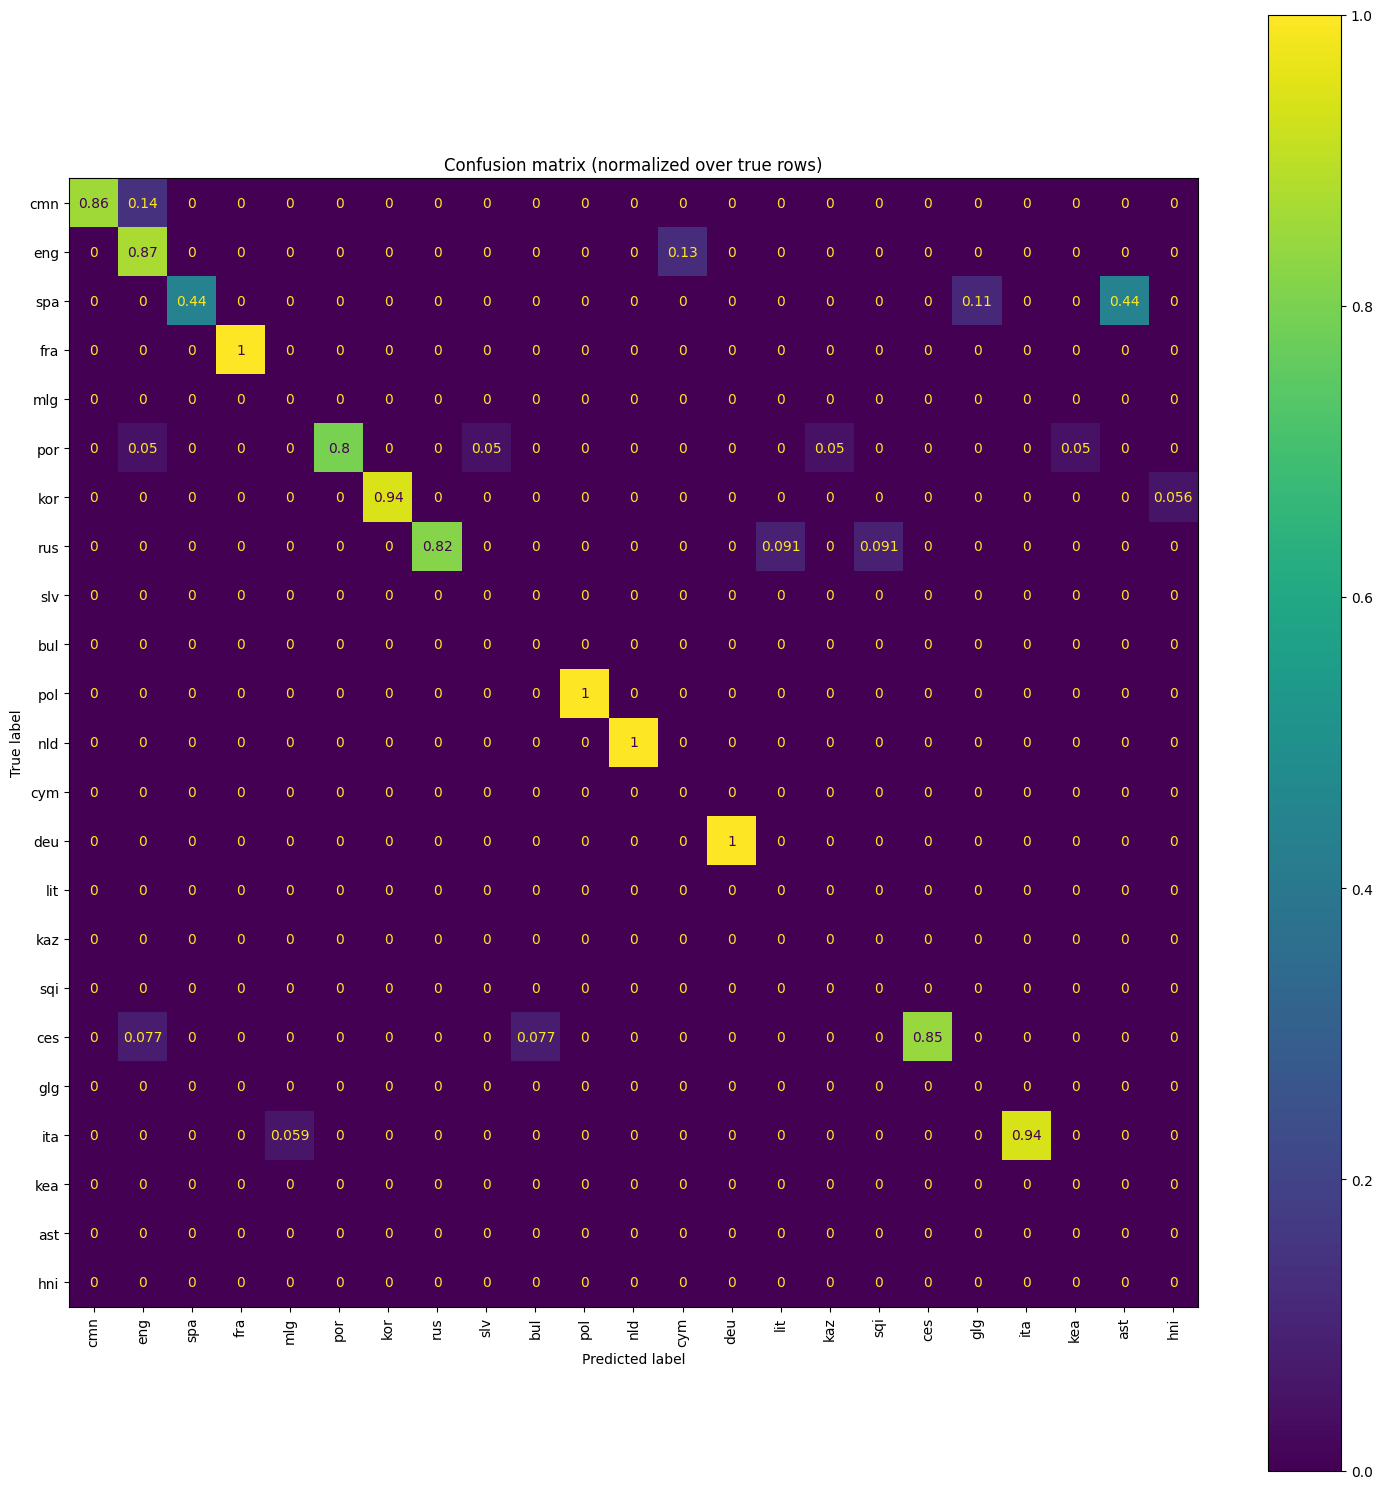

In [46]:
cm = sklearn.metrics.confusion_matrix(
    y_true=label_model_ids,
    y_pred=predictions_model_ids,
    labels=unique_prediction_ids,
    normalize="true",
)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                              display_labels=unique_prediction_labels)

fig, ax = plt.subplots(figsize=(15,15))
ax.set_title("Confusion matrix (normalized over true rows)")

disp.plot(ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
ax.tick_params(axis="x", labelrotation=90)
# Prevent labels from getting cut off when saving image
fig.tight_layout()

fig.savefig(output_dir + "/confusion matrix normalized true.png")
fig.savefig(output_dir + "/confusion matrix normalized true.svg")
fig.show()

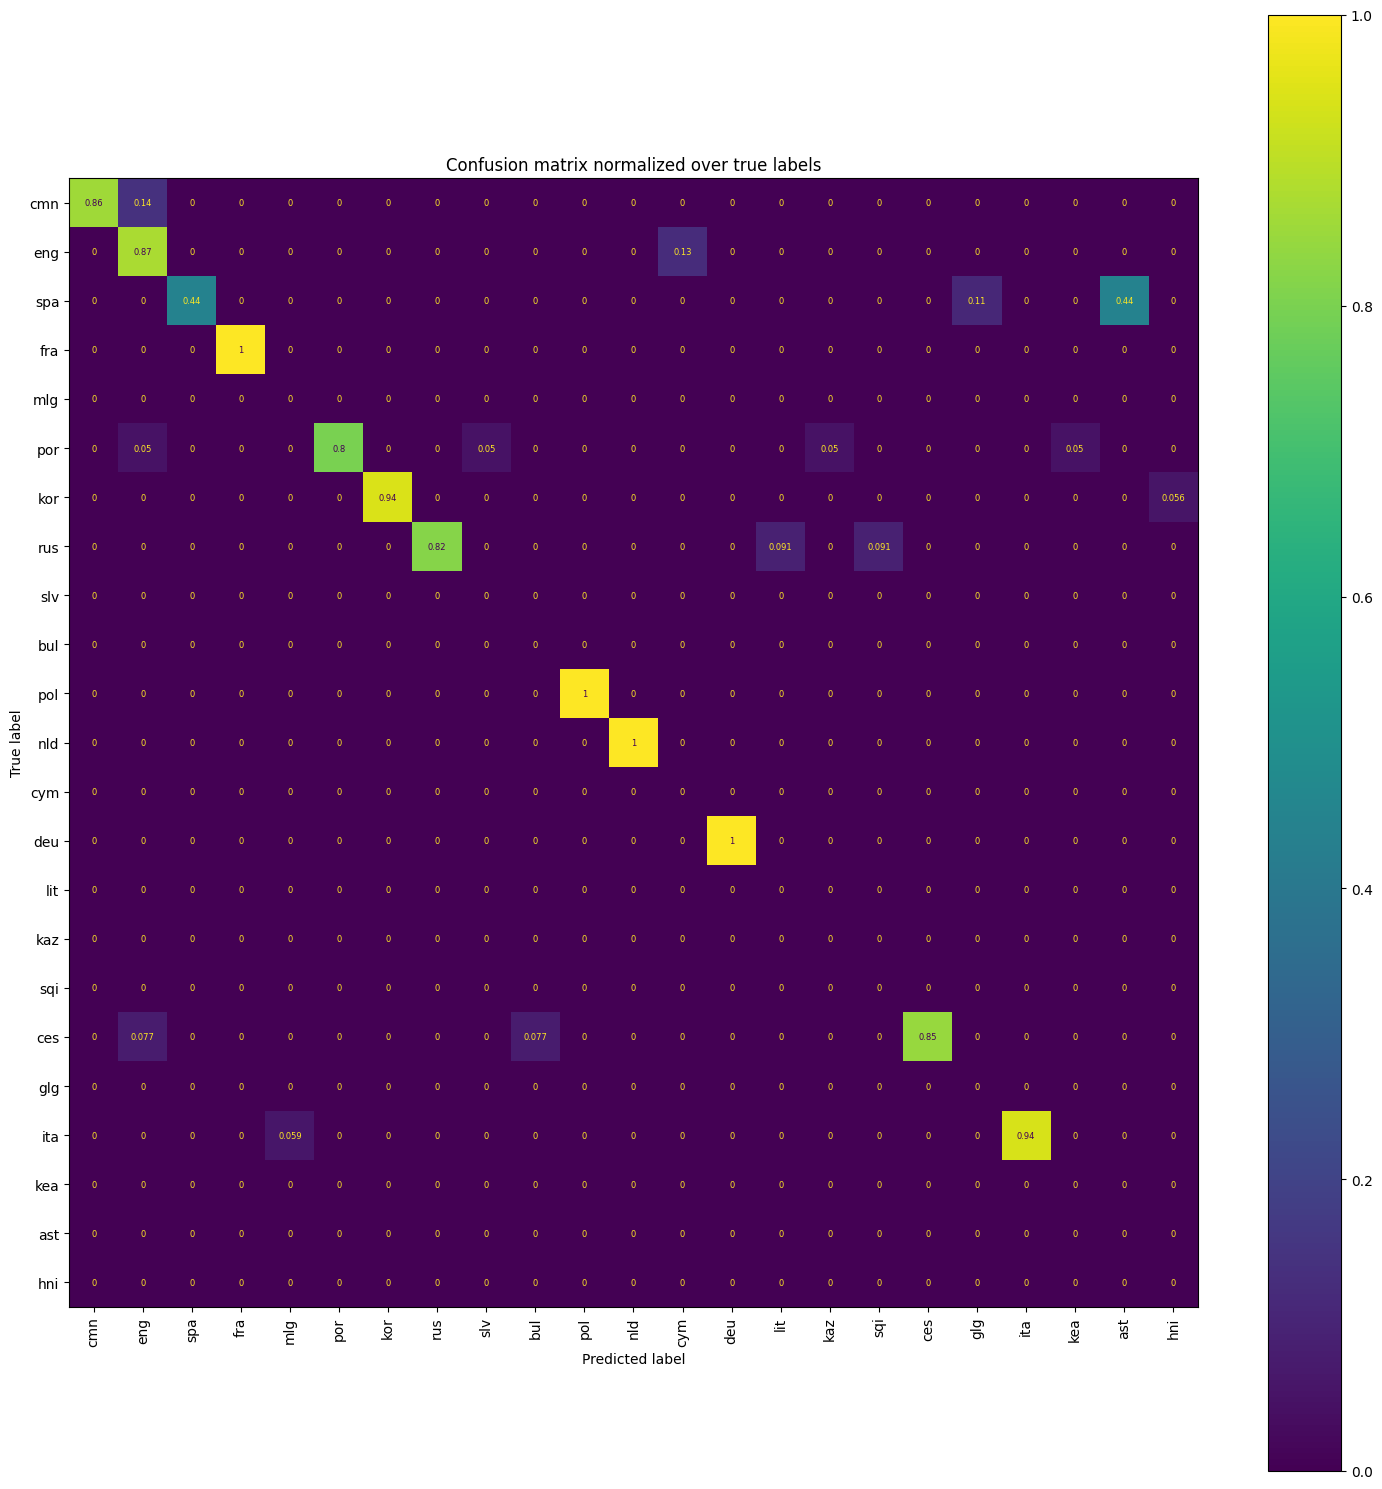

In [47]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_title("Confusion matrix normalized over true labels")

sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
    y_true=label_model_ids,
    y_pred=predictions_model_ids,
    labels=unique_prediction_ids,
    display_labels=unique_prediction_labels,
    normalize="true",
    include_values=True,
    xticks_rotation="vertical",
    ax=ax,
    text_kw={"size": 6},
    values_format=".2g",
)
# Prevent labels from getting cut off when saving image
plt.tight_layout()
plt.savefig(output_dir + "/confusion matrix normalized true small font.png")
plt.savefig(output_dir + "/confusion matrix normalized true small font.svg")
plt.show()

In [48]:
import json
timestamp_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
out_filename = output_dir + "/" + timestamp_str + "_results.json"
with open(out_filename, "w") as out_file:
  results = {
      "labels": label_global_ids,
      "predictions": predictions_global_ids,
  }
  json.dump(results, out_file)

In [49]:
out_filename = output_dir + "/" + timestamp_str + "_results_human.json"
with open(out_filename, "w") as out_file:
  results = {
      "labels": [global_id_to_iso639_part3(id) for id in label_global_ids],
      "predictions": [global_id_to_iso639_part3(id) for id in predictions_global_ids],
  }
  json.dump(results, out_file)

In [36]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  2
  On-line CPU(s) list:   0,1
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:          6
    Model:               79
    Thread(s) per core:  2
    Core(s) per socket:  1
    Socket(s):           1
    Stepping:            0
    BogoMIPS:            4399.99
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clf
                         lush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_
                         good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fm
                         a cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hyp
                         ervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd i